<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

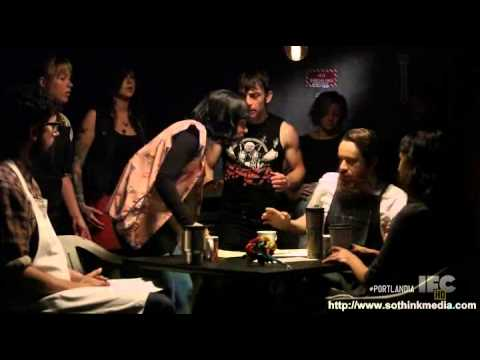

In [28]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [29]:
%pwd

'C:\\Users\\jadam\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [44]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [45]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [46]:
# Start here 
print(shops.shape)
shops.star_rating = shops.star_rating.apply(lambda x: x.rstrip(" star rating"))

(7616, 3)


In [47]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [48]:
def tokenize(obs):
    doc = nlp(obs)
    tokens = []
    for token in doc:
        tokens.append(token)
    return tokens

In [49]:
shops.full_review_text[0][10:]

'6 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [50]:
for i in range(7616):
    shops.full_review_text[i] = shops.full_review_text[i][10:]

In [51]:
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,6 1 check-in Love love loved the atmosphere! E...,5.0
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aus...",4.0
2,The Factory - Cafe With a Soul,6 1 check-in Listed in Brunch Spots I loved th...,4.0
3,The Factory - Cafe With a Soul,6 Very cool decor! Good drinks Nice seating H...,2.0
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northc...,4.0


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [52]:
shops['star_rating'] = shops['star_rating'].astype(float)
shops['rating'] = shops['star_rating'].apply(lambda x: 'Good' if x > 3 else 'Bad')
shops.head()

,coffee_shop_name,full_review_text,star_rating,rating
0,The Factory - Cafe With a Soul,6 1 check-in Love love loved the atmosphere! E...,5.0,Good
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aus...",4.0,Good
2,The Factory - Cafe With a Soul,6 1 check-in Listed in Brunch Spots I loved th...,4.0,Good
3,The Factory - Cafe With a Soul,6 Very cool decor! Good drinks Nice seating H...,2.0,Bad
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northc...,4.0,Good


In [53]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Dealing with stop words, punctuation and pronouns
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [54]:
import re
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [55]:
shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [56]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [57]:
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [58]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,rating,tokens,lemmas
0,The Factory - Cafe With a Soul,6 1 check-in Love love loved the atmosphere! E...,5.0,Good,"[6, 1, checkin, love, love, loved, the, atmosp...","[6, 1, check, Love, love, love, atmosphere, co..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aus...",4.0,Good,"[listed, in, date, night, austin, ambiance, in...","[ , list, Date, Night, Austin, Ambiance, Austi..."
2,The Factory - Cafe With a Soul,6 1 check-in Listed in Brunch Spots I loved th...,4.0,Good,"[6, 1, checkin, listed, in, brunch, spots, i, ...","[6, 1, check, list, Brunch, Spots, love, eclec..."
3,The Factory - Cafe With a Soul,6 Very cool decor! Good drinks Nice seating H...,2.0,Bad,"[6, very, cool, decor, good, drinks, nice, sea...","[6, cool, decor, good, drink, nice, seating, ..."
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northc...,4.0,Good,"[1, checkin, they, are, located, within, the, ...","[ , 1, check, locate, Northcross, mall, shoppi..."


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


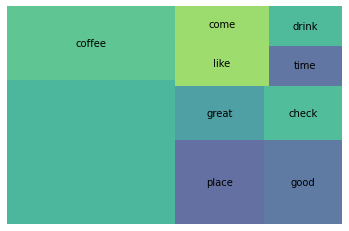

In [59]:
import squarify
import matplotlib.pyplot as plt
wc = count(shops['lemmas'])
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

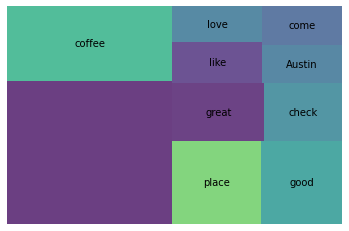

In [60]:
good = shops.loc[shops['rating'] == 'Good']
wc = count(good['lemmas'])
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

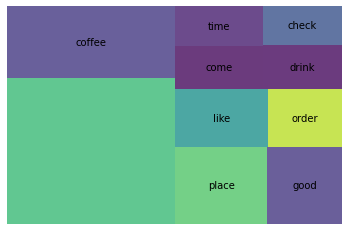

In [61]:
bad = shops.loc[shops['rating'] == 'Bad']
wc = count(bad['lemmas'])
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [62]:
bad.head()

,coffee_shop_name,full_review_text,star_rating,rating,tokens,lemmas
3,The Factory - Cafe With a Soul,6 Very cool decor! Good drinks Nice seating H...,2.0,Bad,"[6, very, cool, decor, good, drinks, nice, sea...","[6, cool, decor, good, drink, nice, seating, ..."
8,The Factory - Cafe With a Soul,"6 1 check-in Ok, let's try this approach... P...",3.0,Bad,"[6, 1, checkin, ok, lets, try, this, approach,...","[6, 1, check, ok, let, try, approach, , pro, ..."
11,The Factory - Cafe With a Soul,"6 The store has A+ decoration, but honestly, t...",3.0,Bad,"[6, the, store, has, a, decoration, but, hones...","[6, store, a+, decoration, honestly, coffee, g..."
12,The Factory - Cafe With a Soul,6 1 check-in Listed in 2016 - The Third Time i...,3.0,Bad,"[6, 1, checkin, listed, in, 2016, the, third, ...","[6, 1, check, list, 2016, time, Charm, Factory..."
25,The Factory - Cafe With a Soul,"Okay, so after visiting my friends in LA and ...",1.0,Bad,"[okay, so, after, visiting, my, friends, in, l...","[ , okay, visit, friend, LA, try, mint, mojito..."


In [63]:
good.head()

,coffee_shop_name,full_review_text,star_rating,rating,tokens,lemmas
0,The Factory - Cafe With a Soul,6 1 check-in Love love loved the atmosphere! E...,5.0,Good,"[6, 1, checkin, love, love, loved, the, atmosp...","[6, 1, check, Love, love, love, atmosphere, co..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aus...",4.0,Good,"[listed, in, date, night, austin, ambiance, in...","[ , list, Date, Night, Austin, Ambiance, Austi..."
2,The Factory - Cafe With a Soul,6 1 check-in Listed in Brunch Spots I loved th...,4.0,Good,"[6, 1, checkin, listed, in, brunch, spots, i, ...","[6, 1, check, list, Brunch, Spots, love, eclec..."
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northc...,4.0,Good,"[1, checkin, they, are, located, within, the, ...","[ , 1, check, locate, Northcross, mall, shoppi..."
5,The Factory - Cafe With a Soul,6 1 check-in Very cute cafe! I think from the ...,4.0,Good,"[6, 1, checkin, very, cute, cafe, i, think, fr...","[6, 1, check, cute, cafe, think, moment, step,..."


In [64]:
STOP_WORDS = nlp.Defaults.stop_words.union(['Austin', 'coffee',' ', '1', 'place', 'austin', '$', '6'])

In [ ]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in nlp.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [ ]:
good = shops.loc[shops['rating'] == 'Good']
wc = count(good['tokens'])
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [ ]:
bad = shops.loc[shops['rating'] == 'Bad']
wc = count(bad['tokens'])
wc_top20 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

